This file allows to analyze results obtained by running experiments_competing_risk.

In [23]:
import os 
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import sys

sys.path.append('../../')
sys.path.append('../../DeepSurvivalMachines/')

from datasets import datasets

In [24]:
# Change this to analyze other datasets result
dataset = 'METABRIC' 

In [25]:
path = '/vol/miltank/users/frou/Documents/TFM_for_medical_prognosis/jobs/scripts/Results/' # Path where the data is saved
x, t, e, cNCriates = datasets.load_dataset(dataset, competing = False, normalize = False) # Open the data

In [26]:
horizons = [0.25, 0.5, 0.75] # Horizons to evaluate the models
times_eval = np.quantile(t[e > 0], horizons)

In [27]:
from pycox.evaluation import EvalSurv
from sksurv.metrics import concordance_index_ipcw, brier_score, cumulative_dynamic_auc, integrated_brier_score
from metrics import truncated_concordance_td, auc_td, brier_score as bs

### Utils: The evaluatino metrics used
def evaluate(survival, e = e, t = t, groups = None, times_eval = []):
    folds = survival.iloc[:, -1].values
    survival = survival.iloc[:, :-1]
    survival.columns = pd.MultiIndex.from_frame(pd.DataFrame(index=survival.columns).reset_index().astype(float))
    
    times = survival.columns.get_level_values(1).unique()
    results = {}

    # If multiple risk, compute cause specific metrics
    for r in survival.columns.get_level_values(0).unique():
        for fold in np.arange(5):
            res = {}
            e_train, t_train = e[folds != fold], t[folds != fold]
            e_test,  t_test  = e[folds == fold], t[folds == fold]
            g_train, g_test = (None, None) if groups is None else (groups[folds != fold], groups[folds == fold])            

            survival_train = survival[folds != fold][r]
            survival_fold = survival[folds == fold][r]

            km = EvalSurv(survival_train.T, t_train, e_train != 0, censor_surv = 'km')
            test_eval = EvalSurv(survival_fold.T, t_test, e_test == int(r), censor_surv = km)

            res['Overall'] = {
                    "CIS": test_eval.concordance_td(), 
                }
            try:
                res['Overall']['BRS'] = test_eval.integrated_brier_score(times.to_numpy())
            except: pass

            km = (e_train, t_train)
            if len(times_eval) > 0:
                for te in times_eval:
                    try:
                        ci, km = truncated_concordance_td(e_test, t_test, 1 - survival_fold.values, times, te, km = km, competing_risk = int(r))
                        res[te] = {
                            "CIS": ci,
                            "BRS": bs(e_test, t_test, 1 - survival_fold.values, times, te, km = km, competing_risk = int(r))[0]}
                    except:
                        pass
                
                    for group in groups.unique() if groups is not None else []:
                        try:
                            km = (e_train[g_train == group], t_train[g_train == group])
                            res[te]["CIS_{}".format(group)] = truncated_concordance_td(e_test[g_test == group], t_test[g_test == group], 1 - survival_fold[g_test == group].values, times, te, km = km, competing_risk = int(r))[0]
                            res[te]["BRS_{}".format(group)] = bs(e_test[g_test == group], t_test[g_test == group], 1 - survival_fold[g_test == group].values, times, te, km = km, competing_risk = int(r))[0]

                            km = (e_train[g_train != group], t_train[g_train != group])
                            res[te]["Delta_CIS_{}".format(group)] = res[te]["CIS_{}".format(group)] - truncated_concordance_td(e_test[g_test != group], t_test[g_test != group], 1 - survival_fold[g_test != group].values, times, te, km = km, competing_risk = int(r))[0]
                            res[te]["Delta_BRS_{}".format(group)] = res[te]["BRS_{}".format(group)] - bs(e_test[g_test != group], t_test[g_test != group], 1 - survival_fold[g_test != group].values, times, te, km = km, competing_risk = int(r))[0]
                        
                        except:
                            pass
            results[(r, fold)] = pd.DataFrame.from_dict(res)
    results = pd.concat(results)
    results.index.set_names(['Risk', 'Fold', 'Metric'], inplace = True)

    return results

In [28]:
groups = None

In [29]:
from experiment import Experiment

In [37]:
# Open file and compute performance
predictions, results, models = {}, {}, {}
for file_name in os.listdir(path):
    if ('cox' not in file_name ) and ('finegray' not in file_name): continue
    if dataset in file_name and '.csv' in file_name: 
        model = file_name       
        model = model[model.rindex('_') + 1: model.index('.')]
        print("Opening :", file_name, ' - ', model)
        predictions[model] = pd.read_csv(path + file_name, header = [0, 1], index_col = 0)

        results[model] = evaluate(predictions[model], groups = groups, times_eval = times_eval)

        model_file = file_name[: file_name.index('.')] + '.pickle'
        try:
            models[model] = Experiment.load(path + model_file)
        except:
            pass

# Rename
# TODO: Add your method in the list for nicer display
dict_name = {'cox': 'CoxPH'} 

results = pd.concat(results).rename(dict_name)
results.index.set_names('Model', level = 0, inplace = True)

Opening : METABRIC_cox.csv  -  cox


In [38]:
# Compute average performance across fold and models
table = results.groupby(['Model', 'Risk', 'Metric']).apply(lambda x:  pd.Series(["{:.3f} ({:.3f})".format(mean, std) for mean, std in zip(x.mean(), x.std())], index = x.columns))
table = table.unstack(level=-1).stack(level=0).unstack(level=-1).loc[:, ['CIS', 'BRS']]
table = table.reorder_levels(['Risk', 'Model']).sort_index(level = 0, sort_remaining = False)

table

Metric                CIS                                      \
                  Overall 42.68333435058594 85.86666870117188   
Risk Model                                                      
1.0  CoxPH  0.635 (0.017)     0.630 (0.018)     0.627 (0.016)   

Metric                                   BRS                    \
           145.33333587646484        Overall 42.68333435058594   
Risk Model                                                       
1.0  CoxPH      0.635 (0.019)  0.146 (0.009)     0.121 (0.009)   

Metric                                           
           85.86666870117188 145.33333587646484  
Risk Model                                       
1.0  CoxPH     0.196 (0.008)      0.222 (0.007)

# Displaying survival curves

Displays the risk scores estimated by both models

In [39]:
models_display = ['cox']

In [40]:
np.random.seed(42)
patient_id = np.random.choice(len(predictions['cox']), size = 5 )

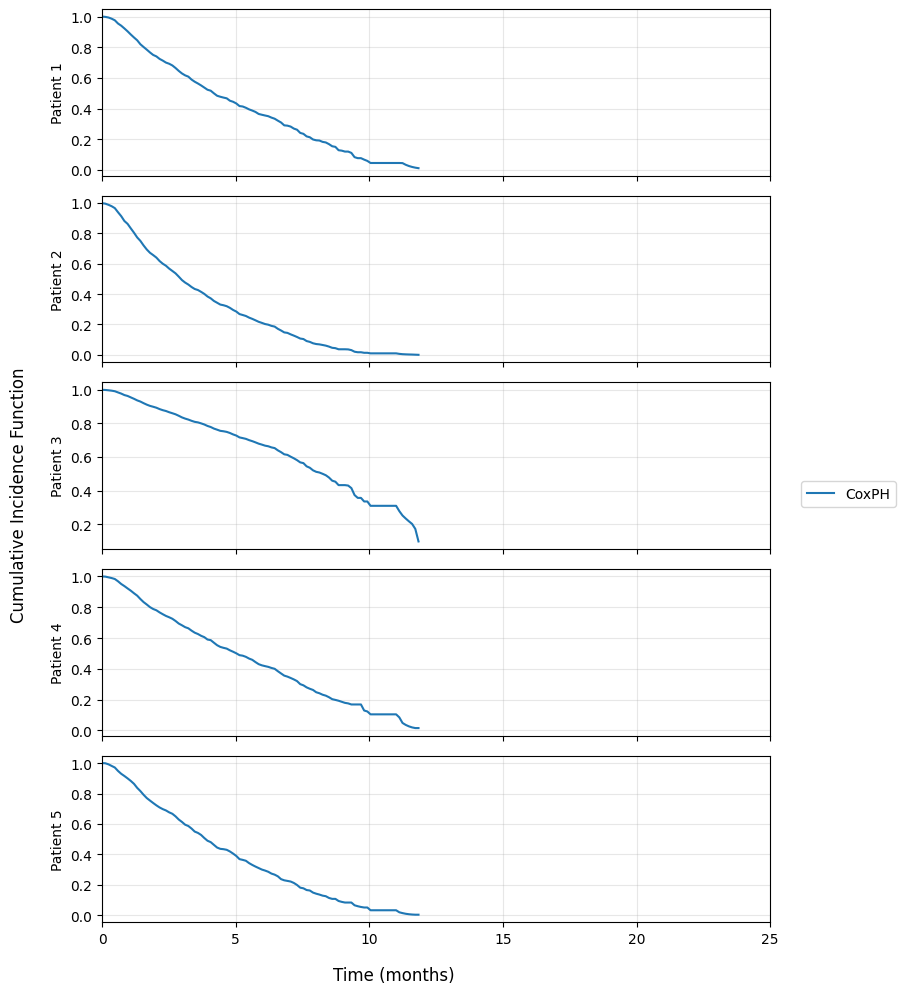

In [43]:
# single-risk plots for selected patients
risks = ['1']                         # only one risk
nrows = len(patient_id)

fig, axes = plt.subplots(nrows, 1, sharex=True, figsize=(8, 2*nrows))
axes = [axes] if nrows == 1 else list(axes)

for i, pid in enumerate(patient_id):
    ax = axes[i]
    for model in models_display:
        s = predictions[model][risks[0]].loc[pid].rename(dict_name[model])
        s.index = s.index.astype(float) / 30  # time in months
        s.plot(ax=ax, legend=False)
    ax.set_xlim(0, 25)
    ax.set_ylabel(f'Patient {i+1}')
    ax.grid(alpha=0.3)

fig.supxlabel('Time (months)')
fig.supylabel('Cumulative Incidence Function')

# one legend for all subplots
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()